# Forecasting - Facebook Prophet
https://facebook.github.io/prophet/

https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

https://peerj.com/preprints/3190.pdf

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [89]:
#attention might have problems with holiday package, 
#downgrate holidays via: pip install 'holidays==0.9.12'
from fbprophet import Prophet 

In [90]:
%matplotlib inline
plt.style.use('fivethirtyeight')

# Trivial Forecasting (rolling mean)

In [91]:
df=pd.DataFrame({'X': np.arange(0, 10)})
df['y']=df.rolling(3).mean()

In [92]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


# Small data set 

In [93]:
df_all=pd.read_csv('../data/processed/COVID_small_flat_table.csv', sep=';')
df=df_all[['date', 'Germany']]
df=df.rename(columns={'date': 'ds', 'Germany': 'y'})

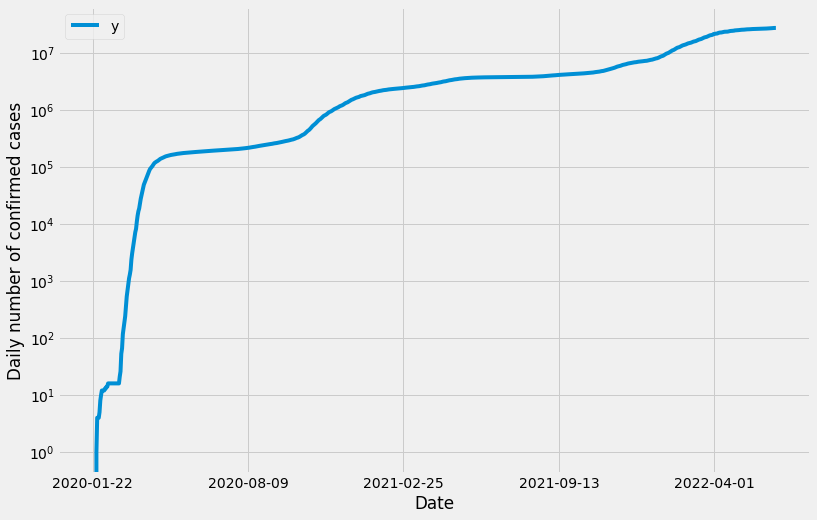

In [94]:
ax=df.set_index('ds').plot(figsize=(12, 8), logy=True)
ax.set_ylabel('Daily number of confirmed cases')
ax.set_xlabel('Date')

plt.show()

In [95]:
#set the uncertainity interval to 95%
# my_model=Prophet(interval_width=0.95)
my_model=Prophet(growth='logistic')

In [96]:
df['cap']=1000000.
my_model.fit(df)

In [97]:
future_dates=my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000.
future_dates.tail()

,ds,cap
882,2022-06-22,1000000.0
883,2022-06-23,1000000.0
884,2022-06-24,1000000.0
885,2022-06-25,1000000.0
886,2022-06-26,1000000.0


In [98]:
forecast=my_model.predict(future_dates)

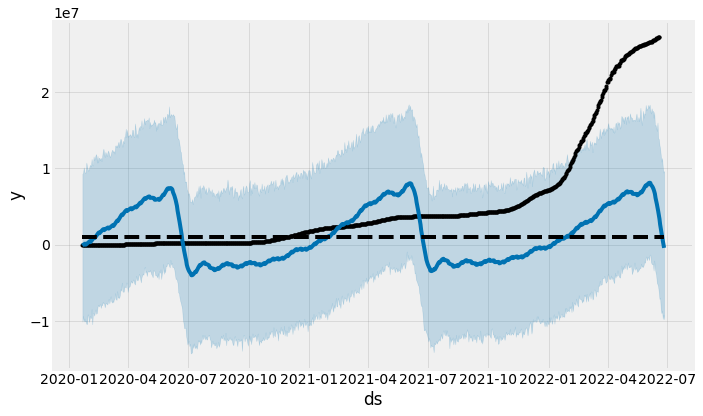

In [99]:
my_model.plot(forecast, uncertainty=True);

In [100]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig= plot_plotly(my_model, forecast)

fig.update_layout(width=1024, height=900, xaxis_title='Time', yaxis_title='Confirmed infected people (source johns hopkins case, log scale)',)
fig.update_yaxes(type='log', range=[1.1, 7.5])
py.iplot(fig)

In [101]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,132658.007738,1000000.0,-1.005747e+07,9.310175e+06,132658.007738,132658.007738,-227066.470601,-227066.470601,-227066.470601,-32111.666754,-32111.666754,-32111.666754,-194954.803847,-194954.803847,-194954.803847,0.0,0.0,0.0,-94408.462863
1,2020-01-23,133865.775596,1000000.0,-9.306324e+06,9.389400e+06,133865.775596,133865.775596,-155546.053521,-155546.053521,-155546.053521,6681.947039,6681.947039,6681.947039,-162228.000560,-162228.000560,-162228.000560,0.0,0.0,0.0,-21680.277925
2,2020-01-24,135082.826871,1000000.0,-1.004128e+07,1.013722e+07,135082.826871,135082.826871,-90692.014788,-90692.014788,-90692.014788,40026.124560,40026.124560,40026.124560,-130718.139348,-130718.139348,-130718.139348,0.0,0.0,0.0,44390.812083
3,2020-01-25,136309.201706,1000000.0,-9.644325e+06,9.624650e+06,136309.201706,136309.201706,-32544.282148,-32544.282148,-32544.282148,67091.808053,67091.808053,67091.808053,-99636.090201,-99636.090201,-99636.090201,0.0,0.0,0.0,103764.919558
4,2020-01-26,137544.939832,1000000.0,-1.003695e+07,9.385069e+06,137544.939832,137544.939832,15761.129757,15761.129757,15761.129757,83910.790476,83910.790476,83910.790476,-68149.660719,-68149.660719,-68149.660719,0.0,0.0,0.0,153306.069589


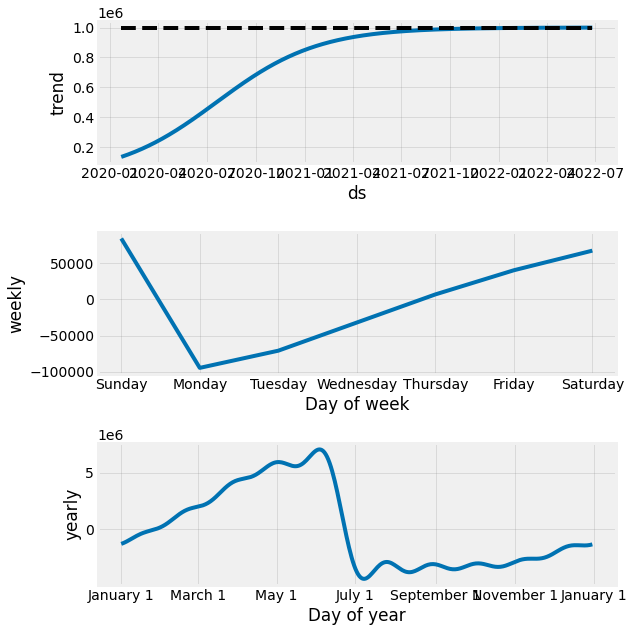

In [102]:
my_model.plot_components(forecast);

<AxesSubplot:xlabel='ds'>

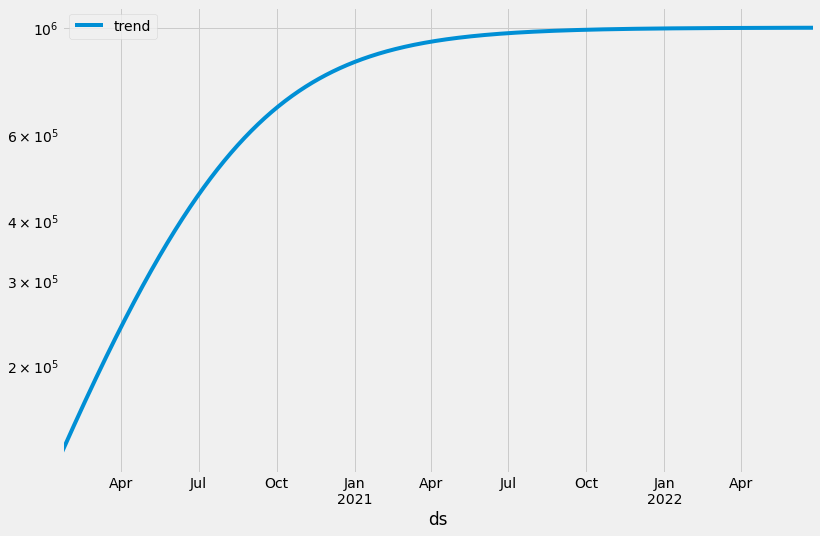

In [103]:
forecast[['ds', 'trend']].set_index('ds').plot(figsize=(12, 8), logy=True)

In [104]:
from fbprophet.diagnostics import cross_validation
df_cv=cross_validation(my_model, initial='90 days', period= '45 days',
horizon = '3 days')

df_cv.head()

  0%|          | 0/18 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-13,172981.322421,172321.332984,173629.878050,171306,2020-05-12
1,2020-05-14,175913.272492,175246.151352,176580.396998,172239,2020-05-12
2,2020-05-15,179723.309259,179014.795417,180423.758135,173152,2020-05-12
3,2020-06-27,192454.894456,191652.339474,193311.052151,193243,2020-06-26
4,2020-06-28,191757.127508,190915.959273,192618.510429,193499,2020-06-26


In [79]:
df_cv.sort_values(by=['cutoff','ds'])[0:12]
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-24,4.859019,-4.845490,14.398080,16,2020-02-23
1,2020-02-25,2.042648,-8.001068,11.386597,16,2020-02-23
2,2020-02-26,-1.212551,-11.636421,8.667837,21,2020-02-23
3,2020-02-27,-2.458346,-13.390341,7.458863,26,2020-02-23
4,2020-02-28,-3.365470,-13.780689,6.400281,53,2020-02-23


In [80]:
df[['ds', 'y']][30:]

,ds,y
30,2020-02-21,16
31,2020-02-22,16
32,2020-02-23,16
33,2020-02-24,16
34,2020-02-25,16
...,...,...
875,2022-06-15,27096571
876,2022-06-16,27124689
877,2022-06-17,27204953
878,2022-06-18,27204955


In [81]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [82]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,7.098866e+13,8.425477e+06,4.580710e+06,0.477755,0.607944,0.136364
1,2 days,7.497588e+13,8.658861e+06,4.724336e+06,0.501835,0.631507,0.136364
2,3 days,7.888634e+13,8.881798e+06,4.864740e+06,0.525778,0.655323,0.045455
3,4 days,8.259314e+13,9.088077e+06,5.000376e+06,0.544241,0.680633,0.045455
4,5 days,8.672569e+13,9.312663e+06,5.143010e+06,0.560387,0.703843,0.000000
5,6 days,9.094154e+13,9.536328e+06,5.284025e+06,0.577232,0.726617,0.000000
6,7 days,9.550849e+13,9.772845e+06,5.429824e+06,0.592135,0.747178,0.000000


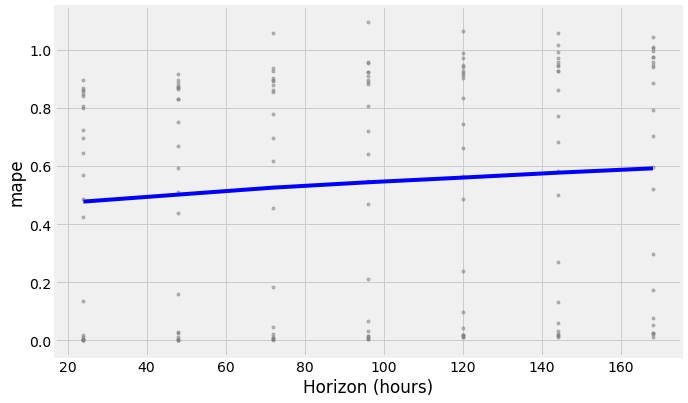

In [83]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', )

# Diagonalplot

gives a good understanding of under and over estimation w.r.t magnitude

In [84]:
horizon='3 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [85]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
125,2022-01-10,401302.017776,-2.224672e+06,3.213263e+06,7535691,2022-01-03,7 days
132,2022-02-19,800602.544846,-2.541947e+06,4.143083e+06,13445094,2022-02-12,7 days
139,2022-03-31,899941.200669,-4.172801e+06,5.817729e+06,21357095,2022-03-24,7 days
146,2022-05-10,674502.422932,-6.777550e+06,8.117781e+06,25503878,2022-05-03,7 days
153,2022-06-19,-221974.195638,-9.322552e+06,8.687624e+06,27211896,2022-06-12,7 days


In [86]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

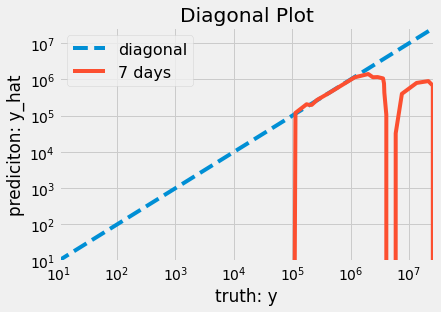

In [87]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forecast

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv', sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date', 'Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds', 'Germany': 'y'})

In [ ]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean()

In [ ]:
df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+ str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 36.77437517212393


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000e+00,NaT,NaN,NaT
3,2020-01-25,0,0.000000e+00,NaT,NaN,NaT
4,2020-01-26,0,0.000000e+00,NaT,NaN,NaT
...,...,...,...,...,...,...
875,2022-06-15,27096571,2.700636e+07,2022-06-08,2.658068e+07,7 days
876,2022-06-16,27124689,2.707623e+07,2022-06-09,2.666073e+07,7 days
877,2022-06-17,27204953,2.714207e+07,2022-06-10,2.673435e+07,7 days
878,2022-06-18,27204955,2.717820e+07,2022-06-11,2.678209e+07,7 days
